## Import the necessary libraries

In [2]:
import os
import glob
import pathlib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Importing all the tensorflow dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense,Conv2D,Flatten

# 🛠 Config

In [3]:
train="../input/100-bird-species/train"
test="../input/100-bird-species/test"
valid="../input/100-bird-species/valid"

In [4]:
len(os.listdir(train))

310

# 🧾Data preprocessing

In [5]:
def process(data):
    path=pathlib.Path(data)#converting the dtring to path
    filepaths=list(path.glob(r"*/*.jpg"))#Going through all the subpaths 
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)#Making the dataframe
    return df

In [6]:
df_train=process(train)
df_test=process(test)
df_valid=process(valid)

In [7]:
df_test.head()

,filepaths,labels
0,../input/100-bird-species/test/WATTLED CURASSO...,WATTLED CURASSOW
1,../input/100-bird-species/test/WATTLED CURASSO...,WATTLED CURASSOW
2,../input/100-bird-species/test/WATTLED CURASSO...,WATTLED CURASSOW
3,../input/100-bird-species/test/WATTLED CURASSO...,WATTLED CURASSOW
4,../input/100-bird-species/test/WATTLED CURASSO...,WATTLED CURASSOW


# 📸 Data Visualization

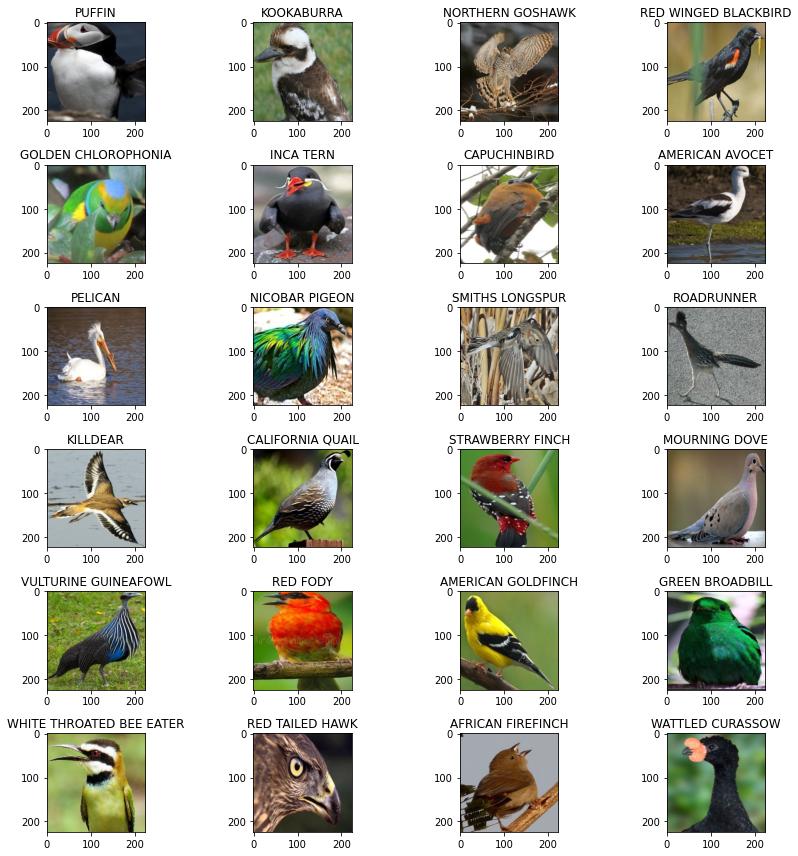

In [8]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random bird pictures
 fig,axes=plt.subplots(nrows=6,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(df_train['filepaths'][i])#reading the image
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()    
plt.show()   

# Data augmentation

#### The dataset is small so we are augmenting the data

In [9]:
train_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
valid_generator=ImageDataGenerator( preprocessing_function=preprocess_input)

## Reading the images from dataframe

In [10]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224,224),
                                                batch_size=16,
                                                subset='training',
                                                random_seed=42)

test_image = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32
)

valid_image = test_generator.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=32
)

Found 45278 validated image filenames belonging to 310 classes.
Found 1550 validated image filenames belonging to 310 classes.
Found 1550 validated image filenames belonging to 310 classes.


## Model building

#### Since we are using ResNet  Let's know a little bit about it

#### What is the ResNet architecture?

#### A residual neural network (ResNet) is an artificial neural network (ANN) of a kind that builds on constructs known from pyramidal cells in the cerebral cortex. Residual neural networks do this by utilizing skip connections, or shortcuts to jump over some layers

In [11]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False#We don't want to train again th resnet

2021-11-02 11:01:47.697407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 11:01:47.791267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 11:01:47.791945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 11:01:47.793002: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [12]:
inputs = pretrained_model.input

x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)#adding some custom layers of our choice

outputs = Dense(310, activation='softmax')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
mo_fit=model.fit(train_image,validation_data=valid_image,epochs=5)

2021-11-02 11:01:52.066193: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2021-11-02 11:01:56.045748: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2830/2830 [==============================] - 441s 153ms/step - loss: 1.4829 - accuracy: 0.6358 - val_loss: 0.4044 - val_accuracy: 0.8800
Epoch 2/5
2830/2830 [==============================] - 154s 55ms/step - loss: 0.5720 - accuracy: 0.8361 - val_loss: 0.3587 - val_accuracy: 0.8877
Epoch 3/5
2830/2830 [==============================] - 172s 61ms/step - loss: 0.4273 - accuracy: 0.8732 - val_loss: 0.3334 - val_accuracy: 0.8961
Epoch 4/5
2830/2830 [==============================] - 157s 56ms/step - loss: 0.3482 - accuracy: 0.8946 - val_loss: 0.3174 - val_accuracy: 0.9103
Epoch 5/5
2830/2830 [==============================] - 157s 56ms/step - loss: 0.3003 - accuracy: 0.9097 - val_loss: 0.3253 - val_accuracy: 0.9071


## Performance plots

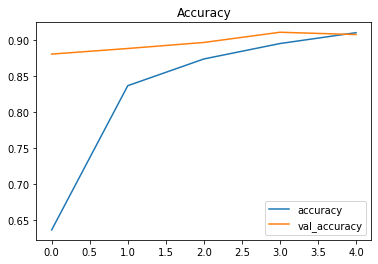

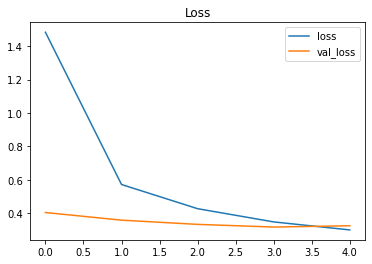

In [16]:
pd.DataFrame(mo_fit.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(mo_fit.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()